**Import Libraries**

In [1]:
#Normal distribution functions
from scipy.stats import norm

# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

# Error Metrics
from sklearn.metrics import mean_squared_error

#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

**Black Scholes Formula**

In [2]:
true_alpha = 0.2
true_beta = 0.2
true_sigma0 = 0.3
interest = 0.1

def vol(moneyness, time):
    return true_sigma0 + true_alpha * time + true_beta * np.square(moneyness - 1)

def call_option_price(moneyness, time, option_vol):
    d1=(np.log(1/moneyness)+(interest + np.square(option_vol))*time)/(option_vol*np.sqrt(time))
    d2=(np.log(1/moneyness)+(interest - np.square(option_vol))*time)/(option_vol*np.sqrt(time))
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    
    return N_d1 - moneyness * np.exp(- interest * time) * N_d2

**Generating Data**

In [3]:
N = 10000

moneys = 1+0.25*np.random.randn(N)
times = np.random.random(N)
volatility = np.array([vol(k,t) for k,t in zip(moneys, times)])
prices = np.array([call_option_price(k,t,sig) for k,t,sig in zip(moneys, times, volatility)])
print('moneys', moneys)
print('times', times)
print('volatility', volatility)
print('prices', prices)

moneys [0.86177731 0.79834377 0.99026323 ... 0.81205239 0.5597212  1.18358148]
times [0.72285257 0.6294755  0.20496783 ... 0.68416636 0.55693474 0.25286339]
volatility [0.44839162 0.43402815 0.34101253 ... 0.44389813 0.45015603 0.35731311]
prices [0.36779412 0.36487894 0.13578726 ... 0.37558188 0.48930467 0.07881561]


**Visualize**

[[0.86177731 0.72285257 0.44839162]
 [0.79834377 0.6294755  0.43402815]
 [0.99026323 0.20496783 0.34101253]
 ...
 [0.81205239 0.68416636 0.44389813]
 [0.5597212  0.55693474 0.45015603]
 [1.18358148 0.25286339 0.35731311]]

[0.36779412 0.36487894 0.13578726 ... 0.37558188 0.48930467 0.07881561]

      Price  Moneyness      Time  Volatility
0  0.367794   0.861777  0.722853    0.448392
1  0.364879   0.798344  0.629476    0.434028
2  0.135787   0.990263  0.204968    0.341013
3  0.161898   1.212549  0.482292    0.405494
4  0.023642   1.124874  0.080666    0.319252


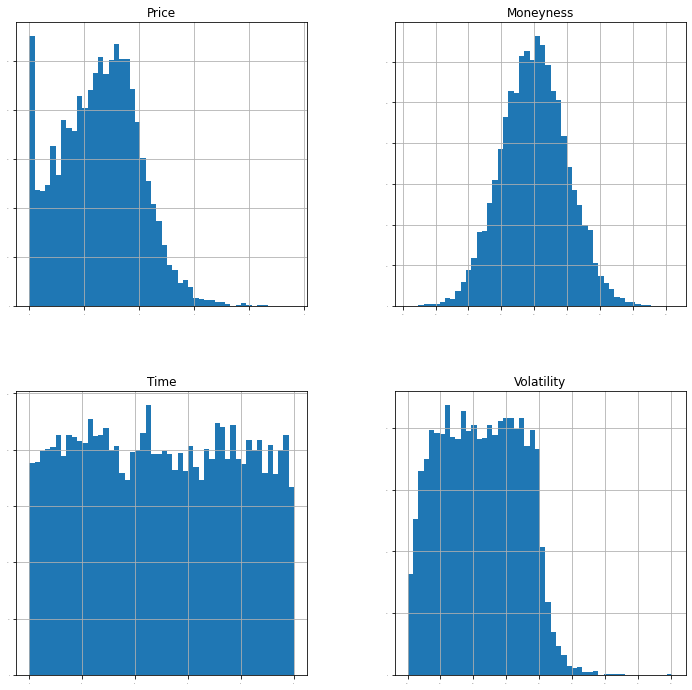

In [4]:
Y = prices
X = np.concatenate([moneys.reshape(-1,1), times.reshape(-1,1), volatility.reshape(-1,1)], axis=1)

dataset = pd.DataFrame(np.concatenate([Y.reshape(-1,1), X], axis=1),
                       columns=['Price', 'Moneyness', 'Time', 'Volatility'])
print(X)
print()
print(Y)
print()
print(dataset.head())
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

**Train Test Split**

In [5]:
#train-test = 80-20
validation_size = 0.2
train_size = int(len(X) * (1-validation_size))
print(train_size)
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

8000


**Models and K-fold Analysis**

In [6]:
models = []

#Linear Models and Regression Trees
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('DT', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

#Neural Network Predictor (Multi Layer Perceptron)
models.append(('MLP', MLPRegressor()))

# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

num_folds = 10
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds)
    
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.000523 (0.000054) 0.000522 0.000509
LASSO: 0.020526 (0.001070) 0.020519 0.020713
EN: 0.020526 (0.001070) 0.020519 0.020713
KNN: 0.000017 (0.000008) 0.000010 0.000017
DT: 0.000021 (0.000006) 0.000000 0.000018
SVR: 0.002808 (0.000073) 0.002782 0.002760
MLP: 0.000036 (0.000016) 0.000040 0.000037
ABR: 0.001240 (0.000036) 0.001159 0.001186
GBR: 0.000044 (0.000004) 0.000034 0.000043
RFR: 0.000005 (0.000005) 0.000001 0.000003
ETR: 0.000002 (0.000004) 0.000000 0.000002


**Results**

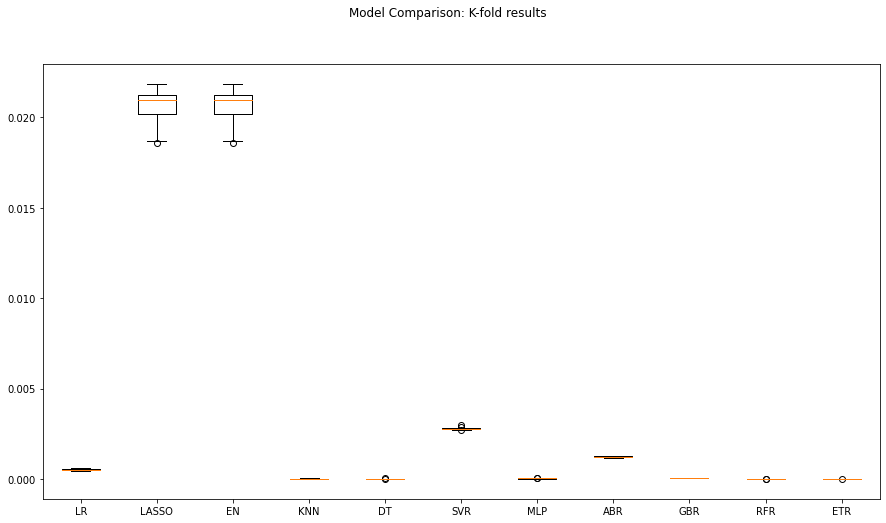

In [7]:
fig = pyplot.figure()
fig.suptitle('Model Comparison: K-fold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

**Remove LASSO and ElasticNet**

LR:   0.000522 0.000509
KNN:   0.000010 0.000017
DT:   0.000000 0.000018
SVR:   0.002782 0.002760
MLP:   0.000040 0.000037
ABR:   0.001159 0.001186
GBR:   0.000034 0.000043
RFR:   0.000001 0.000003
ETR:   0.000000 0.000002


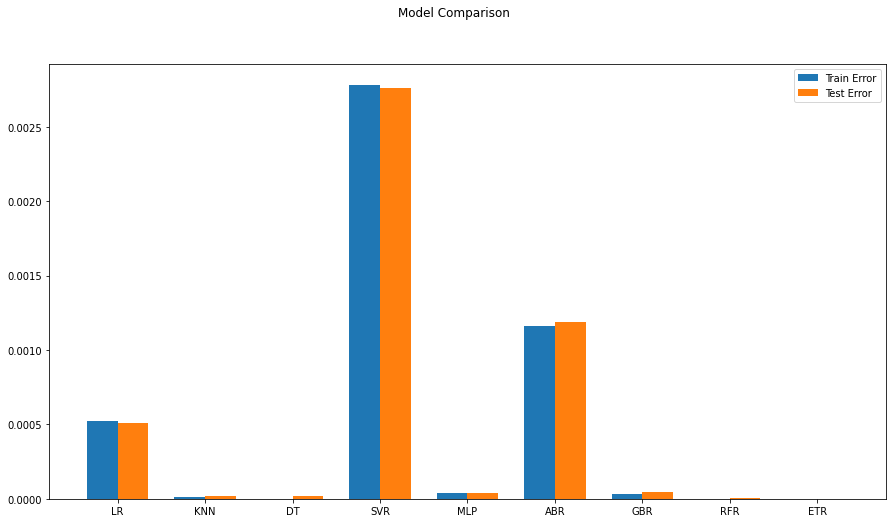

In [8]:
# compare algorithms
fig = pyplot.figure()
train = train_results[0:1] + train_results[3:]
test = test_results[0:1] + test_results[3:]
if 'LASSO' in names:
  names.remove('LASSO')
if 'EN' in names:
  names.remove('EN')

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars
fig.suptitle('Model Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
for i in range(len(train)):
  p = "%s: %10f %f" % (names[i], train[i], test[i])
  print(p)
pyplot.show()

**Improving MLP using GridSearchCV**

In [9]:
param_grid={'hidden_layer_sizes': [(20,), (50,), (20,20), (20, 30, 20)]}
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=MLPRegressor(), param_grid=param_grid, scoring=scoring, cv=kfold)
mlp = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (mlp.best_score_, mlp.best_params_))
print()
#improved MLP
predictions = mlp.predict(X_test)
print(mean_squared_error(Y_test, predictions))

Best: -0.000033 using {'hidden_layer_sizes': (20, 30, 20)}

3.0508182575486105e-05


**Additional analysis: Removing volatility data**

In [10]:
X = np.concatenate([moneys.reshape(-1,1), times.reshape(-1,1)], axis=1)
validation_size = 0.2

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

models = []
#Linear Models and Regression Trees
models.append(('LR', LinearRegression()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('DT', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

#Neural Network Predictor (Multi Layer Perceptron)
models.append(('MLP', MLPRegressor()))

# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))


num_folds = 10
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 


names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds)
    #converted mean square error to positive. The lower the better
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.001592 (0.000158) 0.001589 0.001570
KNN: 0.000017 (0.000008) 0.000010 0.000017
DT: 0.000020 (0.000007) 0.000000 0.000026
SVR: 0.002966 (0.000081) 0.002953 0.002946
MLP: 0.000097 (0.000079) 0.000047 0.000044
ABR: 0.001243 (0.000036) 0.001206 0.001238
GBR: 0.000033 (0.000004) 0.000026 0.000033
RFR: 0.000005 (0.000005) 0.000001 0.000003
ETR: 0.000003 (0.000005) 0.000000 0.000003


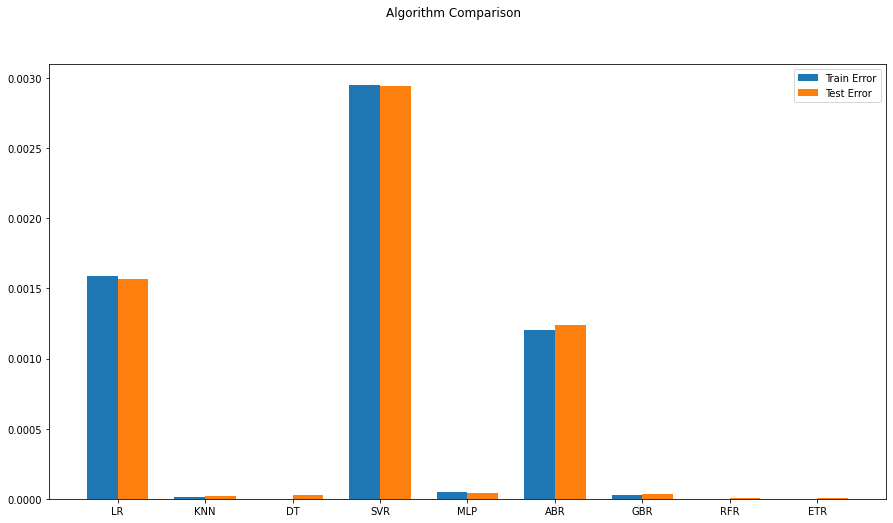

In [11]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()